In [1]:
import sys
sys.path.append("/home/cudaq/Quantum-Sampling/")
from RBM import *
from Sampling import *

In [2]:
import numpy as np

In [3]:
from cudaq import spin

In [4]:
N=4
M=4
beta=1

g=0.5
seed=1

In [5]:
file = "/home/cudaq/Quantum-Sampling/Data/TFIM/"

In [6]:
with open(file+"X_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "rb") as f:
    X = np.loadtxt(f)
X=X[-1,:]

In [7]:
def TFIM(N,g):
    hamiltonian = 0
    for i in range(N-1):
        hamiltonian -= spin.z(i) * spin.z(i+1)

    for i in range(N):
        hamiltonian -= g*spin.x(i)
    return hamiltonian

Ham = TFIM(N,g)
Ham_sq = Ham*Ham

In [8]:
from scipy.sparse import csr_array, coo_matrix
from scipy.sparse.linalg import eigsh

Ham_sp = Ham.to_sparse_matrix()
data, row, col = Ham_sp
Ham_coo = coo_matrix((data, (row, col)), shape=(2**8, 2**8))
Ham_csr = csr_array(Ham_coo)

lmbd, _ = eigsh(Ham_csr, k=1, which='SA')

print("Ground State:", lmbd)

Ground State: [-3.42703409]


In [123]:
from functools import partial

sample_size = 20000

rbm = RBM(N,M,X=X)
a,b,w = rbm.get_params()

prob_func = partial(prob_RBM_nv, params=(a,b,w))

In [135]:
s = rbm.enum(N)

rho_diag = rbm.prob(s)    #Exact
rho_diag = rho_diag / np.sum(rho_diag)

E_loc = rbm.local_op(Ham,s)
E = np.real(np.sum(rho_diag * E_loc) / np.sum(rho_diag))

H2_loc = rbm.local_op(Ham_sq,s)
H2 = np.real(np.sum(rho_diag * H2_loc) / np.sum(rho_diag))
sig = np.sqrt(H2 - E**2)

In [136]:
def E_alpha(s, alpha, prob_dist=rho_diag):
    E_loc = rbm.local_op(Ham,s)
    E = np.real(np.sum(prob_dist * E_loc) / np.sum(prob_dist))

    H2_loc = rbm.local_op(Ham_sq,s)
    H2 = np.real(np.sum(prob_dist * H2_loc) / np.sum(prob_dist))
    
    sig = np.sqrt(H2 - E**2)

    Var_loc = H2_loc - 2*E*E_loc + E**2

    lanczos_kernel = (1+(alpha/sig)*(E_loc-E))**2

    E_diff_loc = ((E_loc - E) + (alpha/sig) * Var_loc ) / (1 + (alpha / sig) * (E_loc - E))

    E_diff = np.sum(lanczos_kernel * E_diff_loc * prob_dist) / np.sum(lanczos_kernel * prob_dist)
    
    return np.real(E_diff + E) 

In [137]:
E_alpha(s, 0)

-3.352768695163307

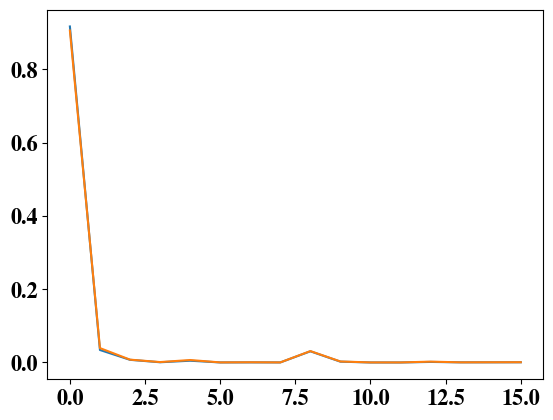

In [138]:
plt.plot(prob_dist)
plt.plot(rho_diag)


In [ ]:
alpha_list = np.arange(-0.15, 0.11, 0.01)
E_alpha_list = []
E_alpha_list_sample = []
for alpha in alpha_list:
    E_alpha_list.append(E_alpha(s, alpha=alpha, prob_dist=rho_diag))

    prob_dist = Sampling(N=N, prob_func=prob_func, sample_size=sample_size, burn=sample_size//10)
    E_alpha_list_sample.append(E_alpha(s, alpha=alpha, prob_dist=prob_dist))

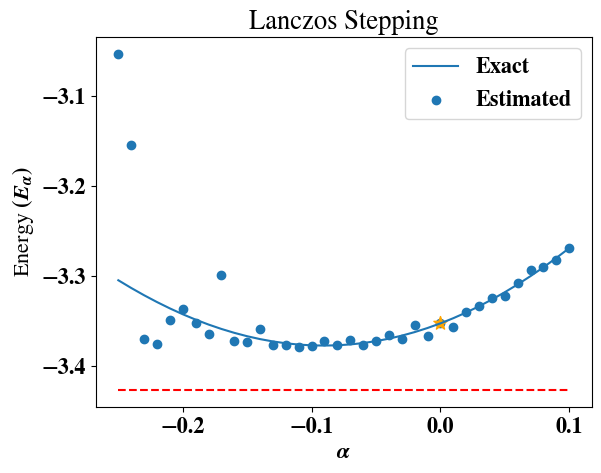

In [180]:
plt.plot(alpha_list, E_alpha_list, label='Exact')
plt.scatter(alpha_list, E_alpha_list_sample,label='Estimated')
plt.scatter([0],E,marker='*',color='orange', s=100)
plt.hlines(lmbd[0], xmin=min(alpha_list), xmax=max(alpha_list), linestyles='dashed',color='r')
plt.xlabel(r'$\alpha$')
plt.ylabel('Energy '+r'$(E_\alpha)$')
#plt.ylim((-3.45,-3.25))
plt.title('Lanczos Stepping')
plt.legend()

In [181]:
mu = ((E_alpha_list - E)/sig *(1+alpha_list**2) - 2*alpha_list) /(alpha_list**2)
alpha_opt = (mu - np.sqrt(mu**2 +4)) / 2

In [182]:
mu

array([ 1.07577262e+01,  1.07787738e+01,  1.08023399e+01,  1.08287364e+01,
        1.08583334e+01,  1.08915734e+01,  1.09289911e+01,  1.09712387e+01,
        1.10191200e+01,  1.10736391e+01,  1.11360658e+01,  1.12080318e+01,
        1.12916691e+01,  1.13898191e+01,  1.15063550e+01,  1.16466979e+01,
        1.18186768e+01,  1.20340338e+01,  1.23112196e+01,  1.26809837e+01,
        1.31986745e+01,  1.39749874e+01,  1.52682108e+01,  1.78532096e+01,
        2.56043094e+01, -9.00719925e+15, -5.38441240e+00,  2.36767764e+00,
        4.95432570e+00,  6.24985559e+00,  7.02912975e+00,  7.55043348e+00,
        7.92445837e+00,  8.20654816e+00,  8.42744741e+00,  8.60560089e+00])

Text(0.5, 0, 'Chosen $\\alpha$')

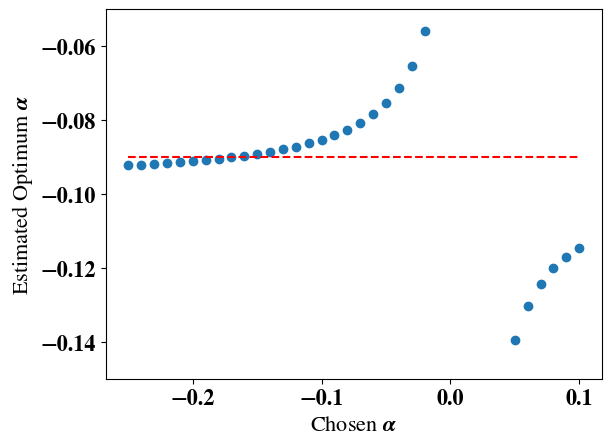

In [183]:
plt.scatter(alpha_list, alpha_opt)
plt.ylim((-0.15,-0.05))
#plt.semilogy
plt.hlines(alpha_list[np.argmin(E_alpha_list)], xmin=min(alpha_list), xmax=max(alpha_list), linestyles='dashed',color='r')
plt.ylabel('Estimated Optimum '+r'$\alpha$')
plt.xlabel('Chosen '+r'$\alpha$')